# Capturing stillness in audience and music

Brouillon for evaluating how audience motion shifts in response to moments of musical stillness. 

    1. Load Stillness moments list
    2. Load measurements of audience motion
    3. Extract summary statistics for audience motion during piece(s): Mean, median, dispersion of some kind, distribution of values continuous?
    4. Evaluate motion around a Stillness moment identified 
    5. Evaluate motion around all moments identified for a piece
    6. test alignment (centre, previous onset, etc.)
    7. test stimulus factors
    8. test conditions (preceeding motion values. Is there a hard limit to how still they get?)

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [156]:
%reload_ext autoreload

In [3]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (fs/2)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [5]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/CopenML_Analysis'

In [6]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [7]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [8]:
Main_concert_times

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,1
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:38:56,-550.16,-550160,Speech,Speech,1087.08,380.52,3
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:47:02,-63.68,-63680,Speech,Speech,1573.56,63.68,5
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,6
2021-10-26 17:48:20,14.38,14380,Clapping for Musicians,Applause,1651.62,43.02,7
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8


In [9]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [10]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),:] # in person hall participant or remote
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
#alignedParts

In [11]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
print(time.time()-tic)

92.15114521980286


In [12]:
#Still_times = pd.read_csv('Stilling_Moments_Beet1.csv',sep=",") #SV alignment for beeps


In [76]:
seg_tag = 'Beethoveen'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]

[seg_start,seg_end ]

[57.4, 1610.36]

In [14]:
seg_tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]

[seg_start,seg_end ]

[2054.48, 3282.36]

In [219]:
seg_tag = 'Second Half'
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[51,0]

[seg_start,seg_end ]

[5274.36, 8042.24]

In [86]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]

[seg_start,seg_end ]

[57.4, 8042.24]

In [77]:
seg_tag = 'Folk'
seg_start = Main_concert_times.iloc[33,0]
seg_end = Main_concert_times.iloc[51,0]

[seg_start,seg_end ]

[6271.28, 8042.24]

In [14]:
seg_tag = 'Bach'
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]

[seg_start,seg_end ]

[2054.48, 3282.36]

In [87]:
Stillings = pd.read_csv(general_loc + 'Stimuli/' + 'Stillings_draft.csv')
Stillings=Stillings.fillna(0)
Stillings= Stillings.set_index('TIME')
Still_times  = Stillings.loc[seg_start:seg_end].copy()
Still_times.iloc[:5,:]

,LABEL,Since,Set,Movement,Moment,PointType,Type,Rest,Gap,Connect,...,Rubato,Rit,Fermata,Precision,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc
TIME,,,,,,,,,,,,,,,,,,,,,
61.320,2.5,3.90,1,1,1,Low_Rest,Rest,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
65.837,4.5,4.52,1,1,2,Low_Rest,Rest_beat,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
79.016,10.25,13.18,1,1,3,Low_Rest,Rest_beat,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
88.256,13,9.24,1,1,4,Low_Rest,Low_onset,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
94.808,17,6.55,1,1,5,Low_Rest,Low_onset,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0


In [88]:
aud_df.index = (ts_ct/1000).round(1)
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)


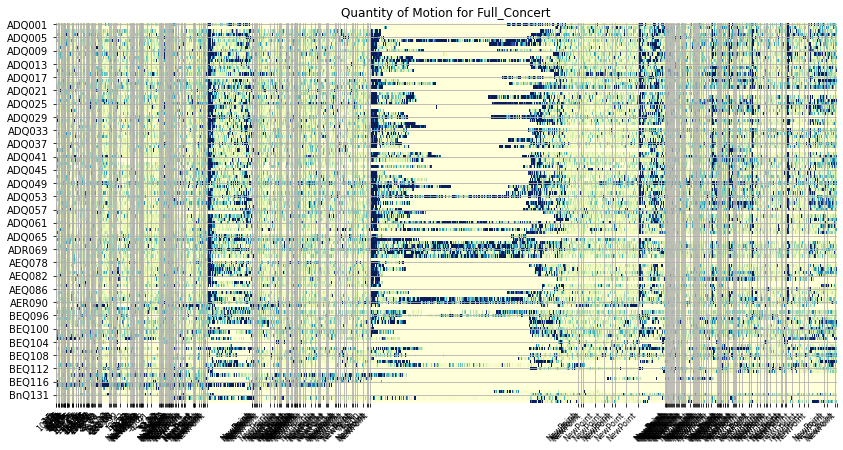

In [89]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,7])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
plt.xticks(new_xticks,Still_times['LABEL'], rotation='45',fontsize=8, ha='right')
plt.grid()
# ax1.set_xticks(new_xticks)
# #ax1.set_xticklabels(seg_times['Event'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion for ' + seg_tag)
#plt.savefig('./Plots/qom_n_full.png',dpi = 300)
plt.show()


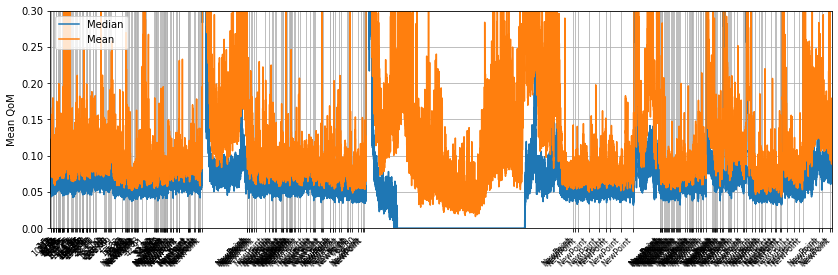

In [90]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,4])
seg_df.median(axis=1).plot(ax=ax1,label='Median')
seg_df.mean(axis=1).plot(ax=ax1,label='Mean')

plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')

plt.xlim([seg_start,seg_end])
plt.ylim([0,0.3])
plt.ylabel('Mean QoM')
plt.grid()
plt.legend()

plt.show()


seg_df = seg_df.fillna(0)

fig,ax = plt.subplots(1,1,figsize=[14,4] )
V = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.loc[i,:]
    pre_snip_df = seg_df.loc[sm['Prev_Beat']-3:sm['Prev_Beat']-0].mean(axis=0).values
    post_snip_df = seg_df.loc[sm['Low_Rest']+0:sm['Low_Rest']+3].mean(axis=0).values
    V.loc[sm['Low_Rest_mm'],:] = post_snip_df-pre_snip_df
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))

V.plot(legend=False,ax=ax)
V.mean(axis=1).plot(ax=ax,color='k',linewidth=2)
plt.xticks(Still_times['Low_Rest_mm'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')
print([V.mean(axis=1).mean(),V.mean(axis=1).sem()])
plt.ylim([-0.1,0.1])
plt.grid()
plt.show()
k

[-0.0027323610738317983, 0.0013269154019866795]


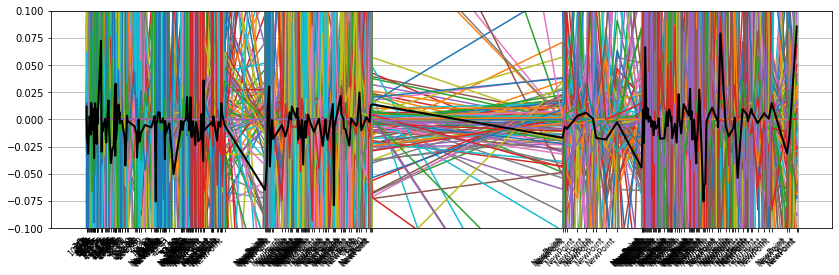

In [110]:
fig,ax = plt.subplots(1,1,figsize=[14,4] )
V = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip_df = seg_df.loc[Otime-3:Otime-2].mean(axis=0).values
    post_snip_df = seg_df.loc[Otime+0:Otime+1].mean(axis=0).values
    V.loc[Otime,:] = post_snip_df-pre_snip_df
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))

V.plot(legend=False,ax=ax)
V.mean(axis=1).plot(ax=ax,color='k',linewidth=2)
plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
print([V.mean(axis=1).median(),V.mean(axis=1).sem()])
plt.ylim([-0.1,0.1])
plt.grid()
plt.show()
#k

In [231]:
sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df)

0.0

In [111]:
Still_times['Ratio'] = k

In [151]:
Still_times.loc[Still_times['Ratio']<0.4,'Moment']

TIME
61.320        1
114.781       7
291.192      27
844.110      61
1226.690     87
1608.510    112
2091.040    116
2667.440    143
3199.330    162
3247.170    164
5776.510    172
6326.430    180
6464.860    191
6568.410    196
6605.740    199
6932.500    219
7169.340    228
7228.910    229
7525.880    239
7588.470    240
8042.220    247
Name: Moment, dtype: int64

In [112]:
print(Still_times.columns)
Still_times=Still_times.fillna(0)
Still_times

Index(['LABEL', 'Since', 'Set', 'Movement', 'Moment', 'PointType', 'Type',
       'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end', 'Phr_begining', 'Rubato',
       'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp', 'Diminuendo', 'TextDec',
       'Drone', 'TextInc', 'Ratio'],
      dtype='object')


,LABEL,Since,Set,Movement,Moment,PointType,Type,Rest,Gap,Connect,...,Rit,Fermata,Precision,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
61.320,2.5,3.90,1,1,1,Low_Rest,Rest,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.382609
65.837,4.5,4.52,1,1,2,Low_Rest,Rest_beat,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495652
79.016,10.25,13.18,1,1,3,Low_Rest,Rest_beat,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.556522
88.256,13,9.24,1,1,4,Low_Rest,Low_onset,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.486957
94.808,17,6.55,1,1,5,Low_Rest,Low_onset,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.408696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7744.900,NewPoint,33.21,8,1,243,Low_Rest,Low_Rest,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.426087
7916.200,NewPoint,171.30,8,1,244,Low_Rest,Low_Rest,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.495652
7942.630,NewPoint,26.43,8,1,245,Low_Rest,Low_Rest,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.478261


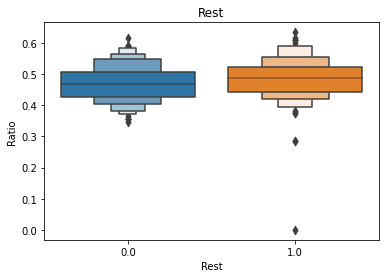

  Source  ddof1  ddof2         F     p-unc      np2
0   Rest      1    245  1.729637  0.189687  0.00701


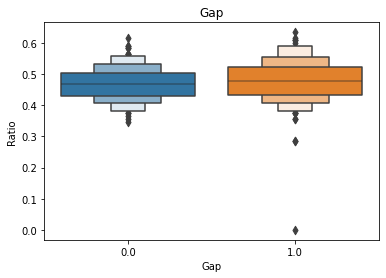

  Source  ddof1  ddof2         F     p-unc       np2
0    Gap      1    245  0.487519  0.485698  0.001986


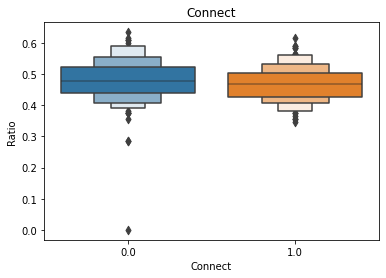

    Source  ddof1  ddof2         F     p-unc       np2
0  Connect      1    245  1.686897  0.195232  0.006838


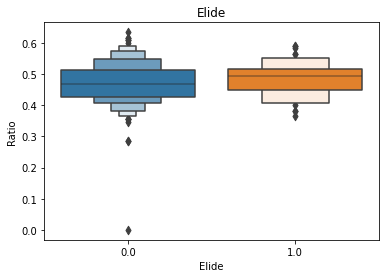

  Source  ddof1  ddof2        F     p-unc       np2
0  Elide      1    245  1.58148  0.209745  0.006414


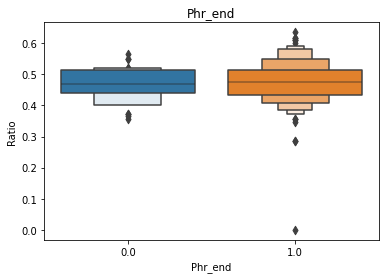

    Source  ddof1  ddof2         F     p-unc       np2
0  Phr_end      1    245  0.385426  0.535291  0.001571


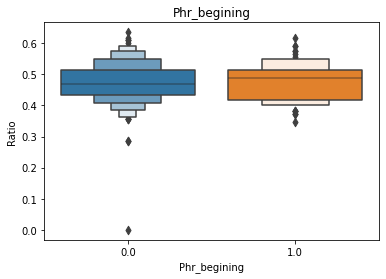

         Source  ddof1  ddof2         F     p-unc       np2
0  Phr_begining      1    245  0.162287  0.687411  0.000662


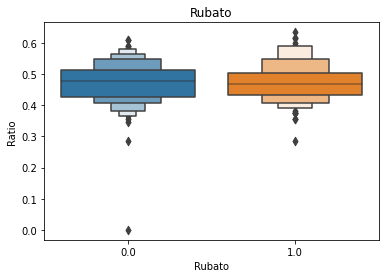

   Source  ddof1  ddof2         F     p-unc           np2
0  Rubato      1    245  0.000156  0.990046  6.366428e-07


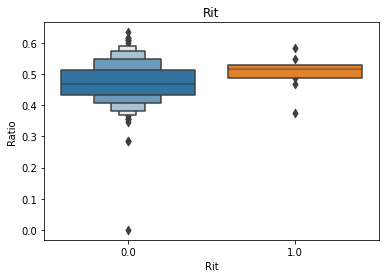

  Source  ddof1  ddof2         F     p-unc       np2
0    Rit      1    245  2.268241  0.133338  0.009173


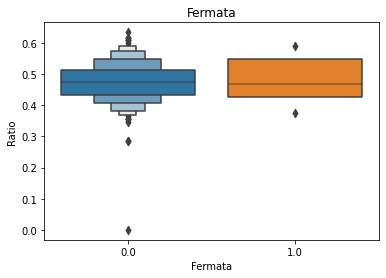

    Source  ddof1  ddof2         F     p-unc       np2
0  Fermata      1    245  0.074644  0.784922  0.000305


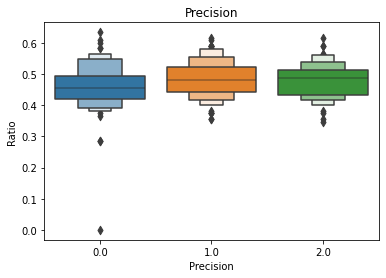

      Source  ddof1  ddof2         F     p-unc       np2
0  Precision      2    244  3.693535  0.026286  0.029385


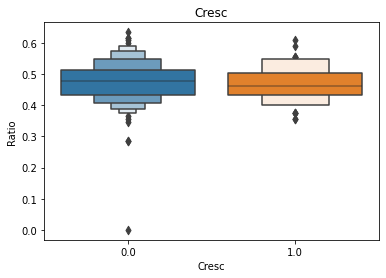

  Source  ddof1  ddof2         F     p-unc      np2
0  Cresc      1    245  0.112644  0.737441  0.00046


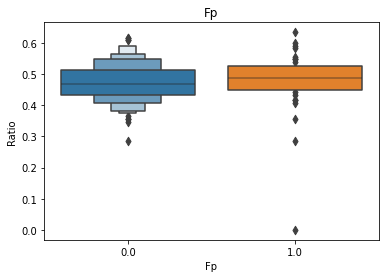

  Source  ddof1  ddof2         F     p-unc       np2
0     Fp      1    245  0.015337  0.901542  0.000063


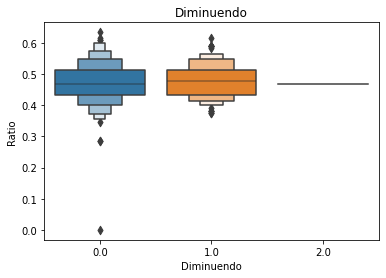

       Source  ddof1  ddof2         F     p-unc       np2
0  Diminuendo      2    244  0.354194  0.702099  0.002895


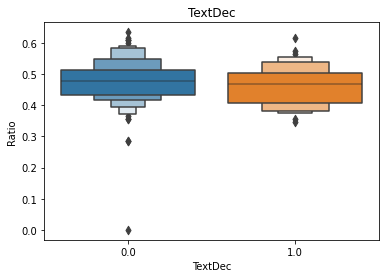

    Source  ddof1  ddof2         F     p-unc       np2
0  TextDec      1    245  1.400906  0.237719  0.005685


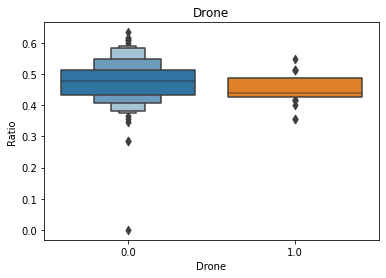

  Source  ddof1  ddof2         F     p-unc       np2
0  Drone      1    245  3.987004  0.046959  0.016013


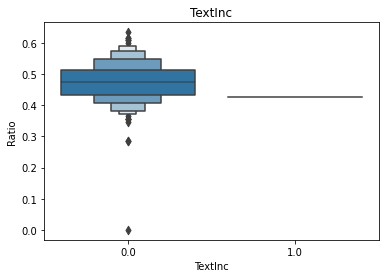

    Source  ddof1  ddof2         F     p-unc       np2
0  TextInc      1    245  0.483417  0.487537  0.001969


In [114]:
features = ['Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc']
for feat in features:
#feat = 'Gap'
    sns.boxenplot(x = feat,y = 'Ratio', data = Still_times)
    plt.title(feat)
    plt.show()

    print(pg.anova(dv="Ratio",between = feat, data=Still_times))

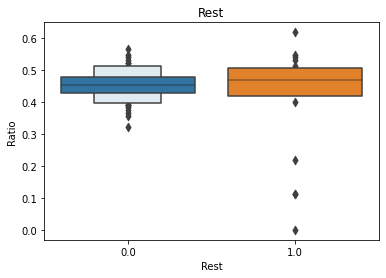

  Source  ddof1  ddof2         F     p-unc       np2
0   Rest      1     80  2.980774  0.088119  0.035921


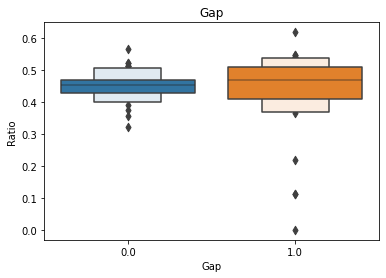

  Source  ddof1  ddof2         F     p-unc       np2
0    Gap      1     80  0.730312  0.395334  0.009046


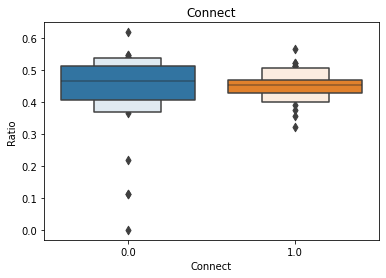

    Source  ddof1  ddof2        F     p-unc      np2
0  Connect      1     80  0.85794  0.357102  0.01061


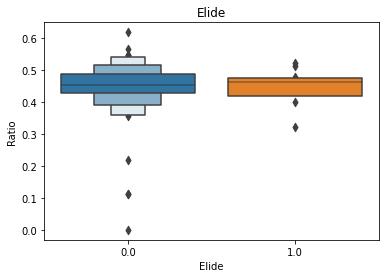

  Source  ddof1  ddof2         F     p-unc       np2
0  Elide      1     80  0.036236  0.849512  0.000453


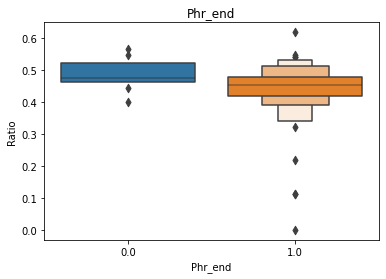

    Source  ddof1  ddof2         F     p-unc       np2
0  Phr_end      1     80  2.053969  0.155707  0.025032


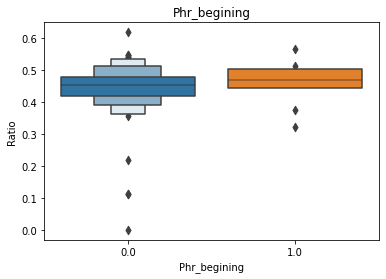

         Source  ddof1  ddof2         F     p-unc       np2
0  Phr_begining      1     80  0.349929  0.555821  0.004355


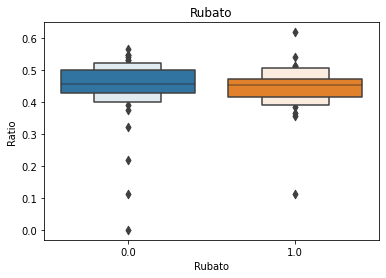

   Source  ddof1  ddof2         F     p-unc       np2
0  Rubato      1     80  0.001197  0.972487  0.000015


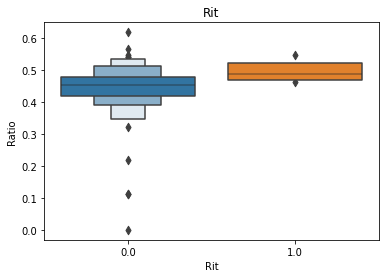

  Source  ddof1  ddof2         F     p-unc       np2
0    Rit      1     80  1.958568  0.165532  0.023897


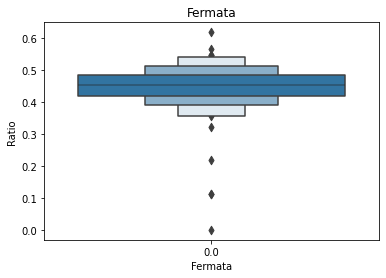

    Source  ddof1  ddof2    F           np2
0  Fermata      0     81  inf  3.287844e-30


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:960: RuntimeWarning: divide by zero encountered in double_scalars
  msbetween = ssbetween / ddof1


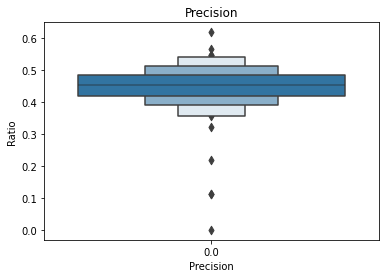

      Source  ddof1  ddof2    F           np2
0  Precision      0     81  inf  3.287844e-30


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:960: RuntimeWarning: divide by zero encountered in double_scalars
  msbetween = ssbetween / ddof1


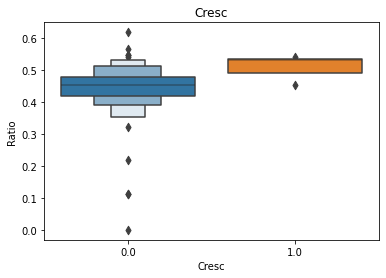

  Source  ddof1  ddof2         F     p-unc       np2
0  Cresc      1     80  1.579076  0.212551  0.019356


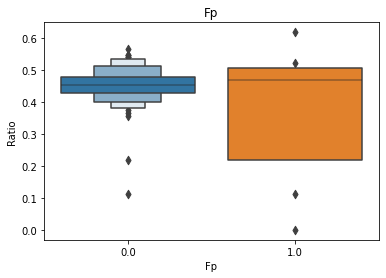

  Source  ddof1  ddof2         F     p-unc       np2
0     Fp      1     80  6.127316  0.015423  0.071143


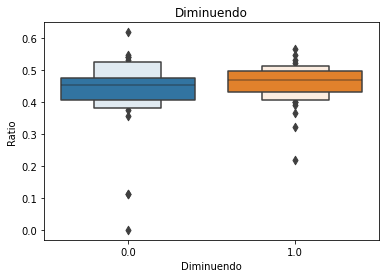

       Source  ddof1  ddof2         F     p-unc       np2
0  Diminuendo      1     80  2.209914  0.141057  0.026881


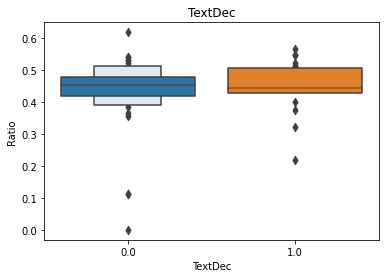

    Source  ddof1  ddof2        F     p-unc       np2
0  TextDec      1     80  0.45127  0.503668  0.005609


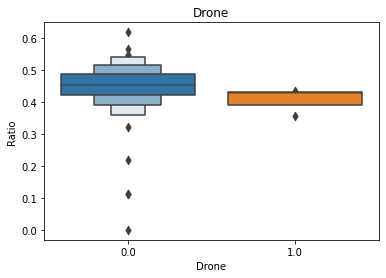

  Source  ddof1  ddof2         F     p-unc       np2
0  Drone      1     80  0.466319  0.496658  0.005795


In [234]:
features = ['Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone']
for feat in features:
#feat = 'Gap'
    sns.boxenplot(x = feat,y = 'Ratio', data = Still_times)
    plt.title(feat)
    plt.show()

    print(pg.anova(dv="Ratio",between = feat, data=Still_times))

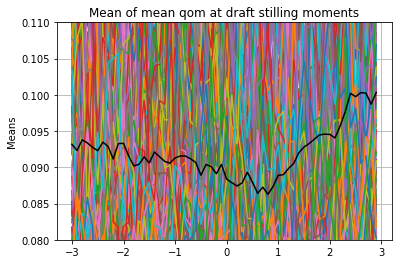

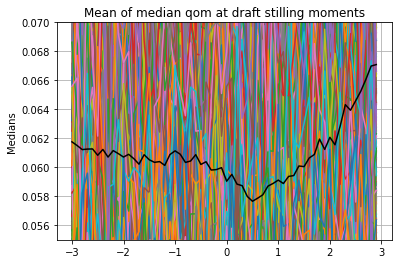

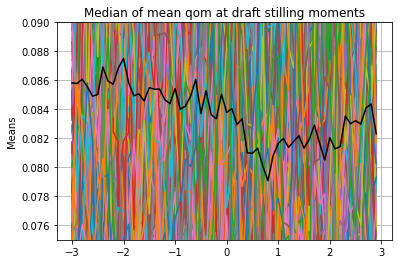

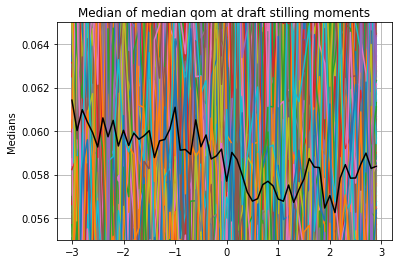

In [118]:
# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Still_times.index)

for i in range(len(Still_times)-1):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.mean(axis=1).plot(color = 'k',legend = False)
plt.title('Mean of mean qom at draft stilling moments')
plt.ylim([0.08,0.11])
plt.ylabel('Means')

plt.grid()
plt.show()

# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.median(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Still_times.index)

for i in range(len(Still_times)-1):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.mean(axis=1).plot(color = 'k',legend = False)
plt.title('Mean of median qom at draft stilling moments')

plt.ylim([0.055,0.07])
plt.ylabel('Medians')
plt.grid()
plt.show()


# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Still_times.index)

for i in range(len(Still_times)-1):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.median(axis=1).plot(color = 'k',legend = False)
plt.title('Median of mean qom at draft stilling moments')
plt.ylim([0.075,0.09])
plt.ylabel('Means')

plt.grid()
plt.show()

# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.median(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Still_times.index)

for i in range(len(Still_times)-1):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.median(axis=1).plot(color = 'k',legend = False)
plt.title('Median of median qom at draft stilling moments')
plt.ylim([0.055,0.065])
plt.ylabel('Medians')
plt.grid()
plt.show()

In [106]:
i

246

# Old thresh evaluations
looking at the distribution of change in QoM over

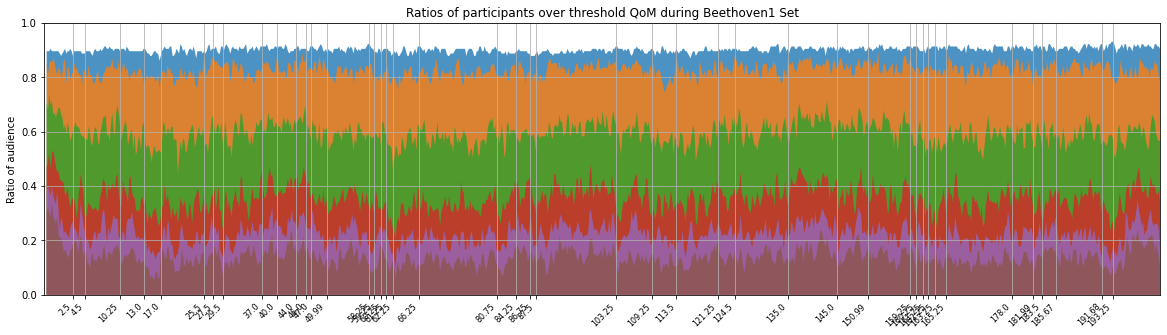

In [25]:
Data = seg_df.copy()
# Data.index = np.arange(0,len(seg_df))/10
musics = 'Beethoven1'

fig,ax = plt.subplots(1,1,figsize=[20,5] )
thresh = np.arange(0.04,0.28,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)
    
# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# new_xticks = cmoments['Time_s'] - concert_times.iloc[50,:]['Time_s']
# plt.xticks(new_xticks,cmoments.Event, rotation='20',fontsize=8)

plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')

plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.savefig('./Plots/ubound_Stillness'+musics+'.png',dpi = 300)
plt.show()

In [28]:
Still_times

,Moment_N,Prev_Beat_mm,Prev_Onset_mm,Low_Rest_mm,Next_Onset_mm,Next_Beat_mm,Prev_Beat,Prev_Onset,Low_Rest,Next_Onset,...,Rit,Fermata,Precision,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc,Piece
0,1,2.00,2.25,2.50,3.00,3.50,59.957,60.629,61.320,62.272,...,NaN,NaN,1,NaN,NaN,1.0,1.0,NaN,NaN,1
1,2,4.00,4.25,4.50,4.68,4.75,64.680,65.221,65.837,66.453,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,9.68,10.00,10.25,10.50,10.50,77.429,78.216,79.016,79.949,...,NaN,NaN,1,NaN,NaN,1.0,1.0,NaN,NaN,1
3,4,12.00,12.50,13.00,13.50,14.00,85.832,87.099,88.256,89.339,...,NaN,NaN,2,NaN,NaN,1.0,NaN,NaN,NaN,1
4,5,16.75,16.92,17.00,17.25,17.50,94.304,94.640,94.808,95.331,...,NaN,NaN,2,1.0,NaN,NaN,1.0,NaN,NaN,1
5,6,25.00,25.38,25.50,25.62,26.00,110.115,110.842,111.085,111.346,...,NaN,NaN,2,NaN,NaN,NaN,1.0,NaN,NaN,1
6,7,27.00,27.38,27.50,27.63,28.00,113.848,114.576,114.781,115.061,...,NaN,NaN,2,NaN,NaN,NaN,1.0,NaN,NaN,1
7,8,29.00,29.38,29.50,29.63,30.00,117.637,118.290,118.515,118.832,...,NaN,NaN,2,NaN,NaN,NaN,1.0,NaN,NaN,1
8,9,36.75,36.88,37.00,37.12,37.25,132.528,132.813,133.152,133.410,...,NaN,NaN,2,NaN,NaN,1.0,NaN,NaN,NaN,1
9,10,39.50,39.92,40.00,40.08,40.50,137.909,138.637,138.824,138.973,...,NaN,NaN,2,1.0,1.0,NaN,NaN,NaN,NaN,1


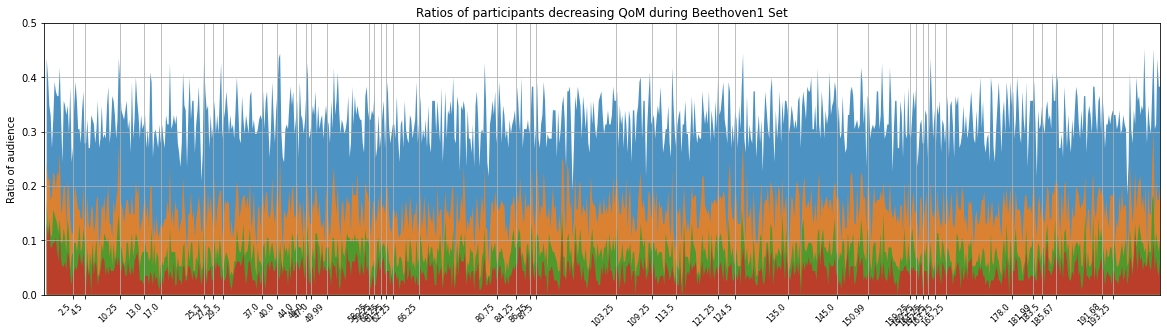

In [27]:
Data = seg_df.copy()
# Data.index = np.arange(0,len(seg_df))/10
musics = 'Beethoven1'

fig,ax = plt.subplots(1,1,figsize=[20,5] )
thresh = np.arange(0.02,0.18,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'Dec')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)
    
# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# new_xticks = cmoments['Time_s'] - concert_times.iloc[50,:]['Time_s']
# plt.xticks(new_xticks,cmoments.Event, rotation='20',fontsize=8)

plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')

plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,0.5])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants decreasing QoM during ' + musics + ' Set')
#plt.savefig('./Plots/ubound_Stillness'+musics+'.png',dpi = 300)
plt.show()

In [47]:
df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133,Total
Time,,,,,,,,,,,,,,,,,,,,,
51.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130435
51.7,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104348
52.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130435
52.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957
53.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478
474.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069565
474.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478


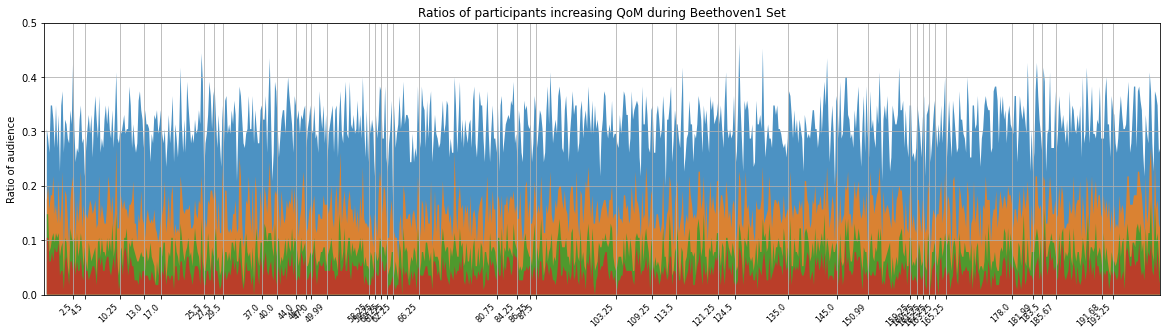

In [41]:
Data = seg_df.copy()
# Data.index = np.arange(0,len(seg_df))/10
musics = 'Beethoven1'

fig,ax = plt.subplots(1,1,figsize=[20,5] )
thresh = np.arange(0.02,0.18,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'Inc')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)
    
# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# new_xticks = cmoments['Time_s'] - concert_times.iloc[50,:]['Time_s']
# plt.xticks(new_xticks,cmoments.Event, rotation='20',fontsize=8)

plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')

plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,0.5])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants increasing QoM during ' + musics + ' Set')
#plt.savefig('./Plots/ubound_Stillness'+musics+'.png',dpi = 300)
plt.show()

In [60]:
# must filter first
Data = seg_df.copy()

for c in Data.columns:
    Data.loc[:,c] = butter_lowpass_filter(Data.loc[:,c], 2, 10, 2)

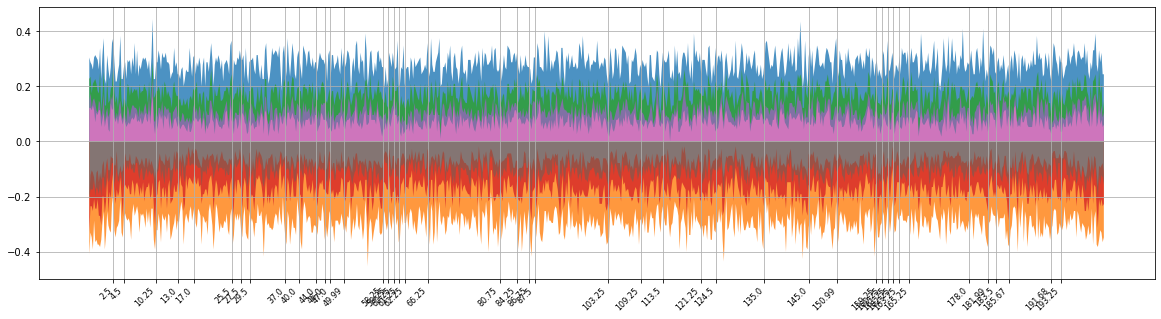

In [61]:
thresh = np.arange(0.02,0.10,0.02)
wind = 1
hop = 0.5
fig,ax = plt.subplots(1,1,figsize=[20,5] )
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    df_threshed['Inc_'+str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label='Inc')

    df = aa.activityCount(Data,wind,hop,th,'Dec')
    df_threshed['Dec_'+str(th)]=-df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = -df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')

plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')

#plt.xlim([950,1900])
plt.grid()
#plt.savefig('./Plots/IncDec_n_'+musics+'2.png',dpi = 300)

plt.show()
#df_threshed.plot()

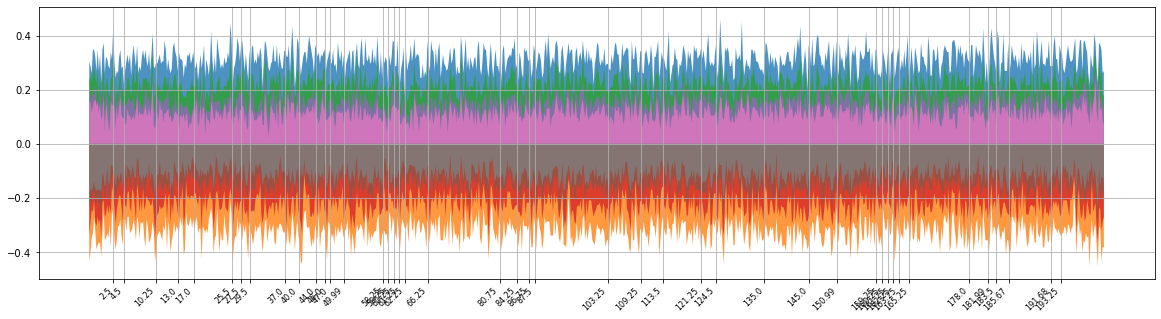

In [59]:
thresh = np.arange(0.02,0.10,0.02)
wind = 1
hop = 0.5
fig,ax = plt.subplots(1,1,figsize=[20,5] )
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    df_threshed['Inc_'+str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label='Inc')

    df = aa.activityCount(Data,wind,hop,th,'Dec')
    df_threshed['Dec_'+str(th)]=-df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = -df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')

plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')

#plt.xlim([950,1900])
plt.grid()
#plt.savefig('./Plots/IncDec_n_'+musics+'2.png',dpi = 300)

plt.show()
#df_threshed.plot()

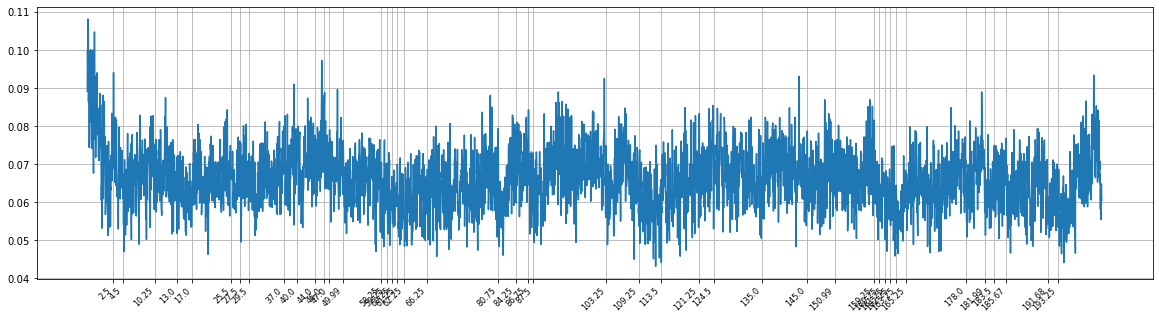

In [137]:
# must filter first
Data = seg_df.iloc[:,0:85].copy()
MD = Data.median(axis=1)
fig,ax = plt.subplots(1,1,figsize=[20,5] )
MD.plot(ax = ax)
plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')
plt.grid()



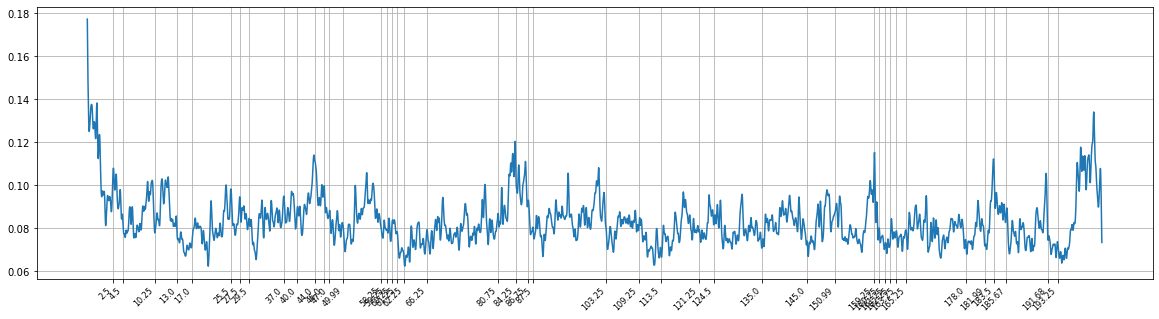

In [143]:
# must filter first
Data = seg_df.iloc[:,0:85].copy()


for c in Data.columns:
    Data.loc[:,c] = butter_lowpass_filter(Data.loc[:,c],1, 10, 2)

MD = Data.mean(axis=1)
fig,ax = plt.subplots(1,1,figsize=[20,5] )
MD.plot(ax = ax)
plt.xticks(Still_times['Low_Rest'],Still_times['Low_Rest_mm'], rotation='45',fontsize=8, ha='right')
plt.grid()



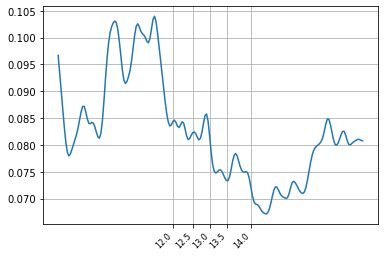

,Connect,Elide,Phr_end,Phr_begining,Rubato,Rit,Fermata,Precision,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc,Piece
3,1.0,NaN,1.0,1.0,NaN,NaN,NaN,2,NaN,NaN,1.0,NaN,NaN,NaN,1


In [152]:
# pull out specific intervals according to each moment. 
Buffer_time = 10
i = 4
sm = Still_times.loc[Still_times.Moment_N == i,:]
cen = sm.Low_Rest.values[0]
SM = MD.loc[cen-Buffer_time:cen+Buffer_time]
SM.plot()
plt.xticks(sm.values[0][6:11],sm.values[0][1:6], rotation='45',fontsize=8, ha='right')
plt.grid()
plt.show()
sm.iloc[:,13:]

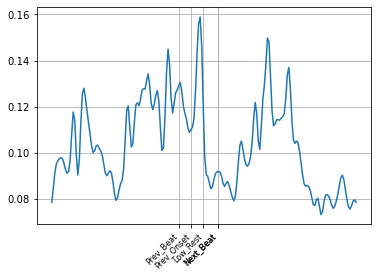

In [121]:
# pull out specific intervals according to each moment. 
Buffer_time = 10
i = 3
sm = Still_times.loc[Still_times.Moment_N == i,:]
cen = sm.Low_Rest.values[0]
SM = MD.loc[cen-Buffer_time:cen+Buffer_time]
SM.plot()
sm
plt.xticks(sm.values[0][6:11],sm.columns[6:11], rotation='45',fontsize=8, ha='right')
plt.grid()


In [95]:
sm.columns[1:6]

Index(['Prev_Beat_mm', 'Prev_Onset_mm', 'Low_Rest_mm', 'Next_Onset_mm',
       'Next_Beat_mm'],
      dtype='object')

In [106]:
sm.values[0][6:11]

array([94.304, 94.64, 94.808, 95.331, 95.834], dtype=object)

In [101]:
SM

79.9     0.066290
80.0     0.053977
80.1     0.065117
80.2     0.062954
80.3     0.058824
           ...   
109.4    0.074870
109.5    0.063246
109.6    0.062741
109.7    0.057947
109.8    0.052398
Length: 300, dtype: float64

In [102]:
sm

,Moment_N,Prev_Beat_mm,Prev_Onset_mm,Low_Rest_mm,Next_Onset_mm,Next_Beat_mm,Prev_Beat,Prev_Onset,Low_Rest,Next_Onset,...,Rit,Fermata,Precision,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc,Piece
4,5,16.75,16.92,17.0,17.25,17.5,94.304,94.64,94.808,95.331,...,NaN,NaN,2,1.0,NaN,NaN,1.0,NaN,NaN,1


# New exatraction criteria?

Use two features of the audio to identify potential stillness moments across the pieces. 

Combine note onset density and amplitude envelope

In [64]:
seg_tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()

[seg_start,seg_end ]

[2054.48, 3282.36]

In [119]:
SoundAmp = pd.read_csv(general_loc + 'Stimuli/' + 'amplitude_env.csv')
# Onsets_stqt.csv midi_set.csv
#Stillings=Stillings.fillna(0)
SoundAmp= SoundAmp.set_index('TIME')
# SoundFeat  = SoundAmp.loc[seg_start:seg_end].copy()
ts_ft = np.arange(0,8945, 0.1)#*1000 
reSound = pd.DataFrame(index = ts_ft)
f = interpolate.interp1d(SoundAmp.index, SoundAmp.VALUE,fill_value='extrapolate')
reSound['SoundAmp'] = f(ts_ft)
# SoundFeat.iloc[:5,:]

In [128]:
ts_ft = np.arange(0,8942, 0.1)#*1000 
reSound = pd.DataFrame(index = ts_ft)
f = interpolate.interp1d(SoundAmp.index, SoundAmp.VALUE,fill_value='extrapolate')
reSound['SoundAmp'] = f(ts_ft)/0.25

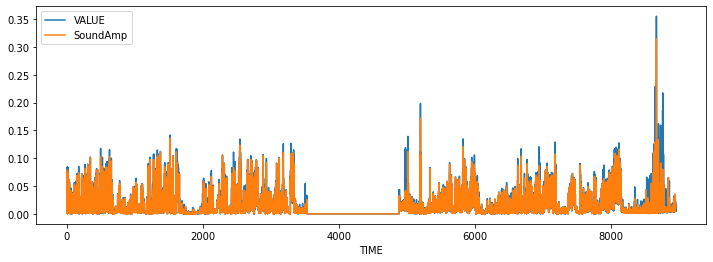

In [121]:
fig,ax = plt.subplots(1,1,figsize=[12,4] )
SoundAmp.plot(ax=ax)
reSound.plot(ax=ax)
plt.show()

,VALUE,LABEL
TIME,,
57.90,220.0000,[1] A3
57.92,233.0820,[1] A#3
57.94,246.9420,[1] B3
58.32,246.9420,[1] B3
59.10,69.2957,[1] C#2


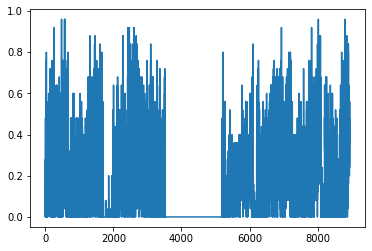

In [129]:
Onsets = pd.read_csv(general_loc + 'Stimuli/' + 'Onsets_stqt.csv')
OnsetsII = pd.read_csv(general_loc + 'Stimuli/' + 'Onsets_stqt5188p287.csv')
OnsetsII['TIME'] = OnsetsII['TIME']+ 5188.287
Onsets = pd.concat([Onsets,OnsetsII])
# Onsets_stqt.csv midi_set.csv 5188.287  Onsets_stqt5188p287.csv
Onsets= Onsets.set_index('TIME')
SoundFeat  = Onsets.loc[seg_start:seg_end].copy()
wind = 1
counts = []
for t in ts_ft:
    counts.append(len(Onsets.loc[t:t+wind]))
    
reSound['OnsetRate'] = np.array(counts)/25 
reSound['OnsetRate'].plot()
SoundFeat.iloc[:5,:]

In [130]:
reSound

,SoundAmp,OnsetRate
0.0,0.316675,0.16
0.1,0.105875,0.12
0.2,0.054245,0.12
0.3,0.036024,0.12
0.4,0.014686,0.12
...,...,...
8941.5,0.052361,0.44
8941.6,0.079211,0.48
8941.7,0.042663,0.36
8941.8,0.054823,0.36


This uses a plug in in sonic visualiser to get the approximate note onsets. Silvet note transcription, with string quartet settings. the result isn't a perfect eval of each note, but it does seem to vary reasonably in time. Designed for multi-instrumental onset detection, much better than the scared.

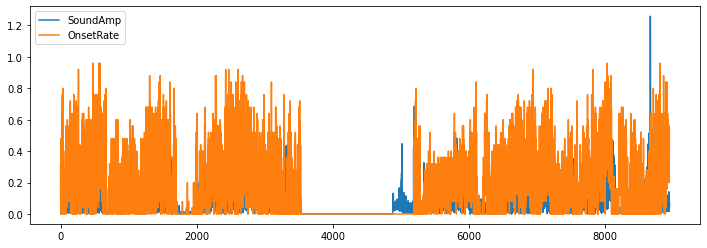

In [131]:
fig,ax = plt.subplots(1,1,figsize=[12,4] )
reSound.plot(ax=ax)
#reSound.plot(ax=ax)
plt.show()

<AxesSubplot:>

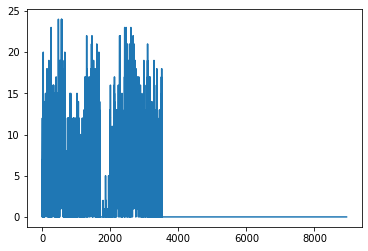

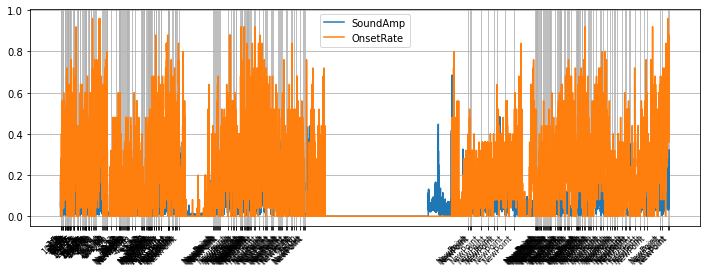

,SoundAmp,OnsetRate
SoundAmp,1.000000,0.589951
OnsetRate,0.589951,1.000000


In [133]:
SoundFeat  = reSound.loc[seg_start:seg_end].copy()
SoundFeat.plot(figsize=(12,4))
SoundFeat.corr(method='spearman')
plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
plt.grid()
plt.show()
SoundFeat.corr(method='spearman')

In [63]:
86*60+28+0.287

5188.287

## extract the features per instance


In [148]:
Stillings.columns

Index(['LABEL', 'Since', 'Set', 'Movement', 'Moment', 'PointType', 'Type',
       'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end', 'Phr_begining', 'Rubato',
       'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp', 'Diminuendo', 'TextDec',
       'Drone', 'TextInc'],
      dtype='object')

[0.041847361680668695, 0.003303496692450207]


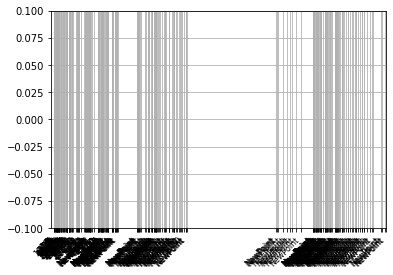

TypeError: corr() got an unexpected keyword argument 'methode'

In [137]:
#fig,ax = plt.subplots(1,1,figsize=[14,4])
V = pd.DataFrame(index = Stillings.index)
SF = reSound['SoundAmp']
pre = []
post = []
ch = []
for i in range(len(Stillings.index)): # reSound
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].mean()
    post_snip = SF.loc[Otime+0:Otime+1].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['SoundAmp_pre'] = pre
V['SoundAmp_post'] = post
V['SoundAmp_shift'] = ch

SF = reSound['OnsetRate']
pre = []
post = []
ch = []
for i in range(len(Stillings.index)): # reSound
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].mean()
    post_snip = SF.loc[Otime+0:Otime+1].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['OnsetRate_pre'] = pre
V['OnsetRate_post'] = post
V['OnsetRate_shift'] = ch




In [155]:
SF = seg_df.mean(axis=1)
pre = []
post = []
ch = []
for i in range(len(Stillings.index)): # reSound
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].mean()
    post_snip = SF.loc[Otime+0:Otime+1].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['QoMmean_pre'] = pre
V['QoMmean_post'] = post
V['QoMmean_shift'] = ch

SF = seg_df.median(axis=1)
pre = []
post = []
ch = []
for i in range(len(Stillings.index)): # reSound
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].mean()
    post_snip = SF.loc[Otime+0:Otime+1].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['QoMmedian_pre'] = pre
V['QoMmedian_post'] = post
V['QoMmedian_shift'] = ch


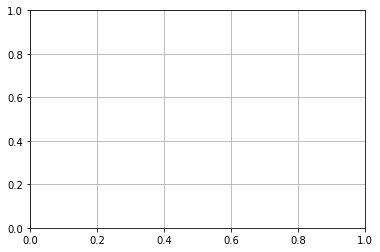

,SoundAmp_pre,SoundAmp_post,SoundAmp_shift,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift
SoundAmp_pre,1.000000,0.562516,-0.879989,0.458098,0.153625,-0.299131,0.313205,0.214815,-0.090591,0.458046,0.417060,-0.065488
SoundAmp_post,0.562516,1.000000,-0.198489,0.419416,0.325310,-0.149603,0.242580,0.271356,0.066020,0.376556,0.481205,0.131127
SoundAmp_shift,-0.879989,-0.198489,1.000000,-0.303010,-0.014168,0.274239,-0.212714,-0.105480,0.119689,-0.317584,-0.258716,0.103092
OnsetRate_pre,0.458098,0.419416,-0.303010,1.000000,0.275602,-0.627230,0.232570,0.202589,-0.035578,0.342583,0.360918,0.022863
OnsetRate_post,0.153625,0.325310,-0.014168,0.275602,1.000000,0.483146,0.199806,0.176539,-0.024252,0.236088,0.246545,0.044193
OnsetRate_shift,-0.299131,-0.149603,0.274239,-0.627230,0.483146,1.000000,-0.052658,-0.043246,0.025880,-0.112993,-0.154573,-0.008290
QoMmean_pre,0.313205,0.242580,-0.212714,0.232570,0.199806,-0.052658,1.000000,0.663971,-0.438469,0.742603,0.643898,-0.189468
QoMmean_post,0.214815,0.271356,-0.105480,0.202589,0.176539,-0.043246,0.663971,1.000000,0.272604,0.639655,0.737569,0.089159
QoMmean_shift,-0.090591,0.066020,0.119689,-0.035578,-0.024252,0.025880,-0.438469,0.272604,1.000000,-0.183856,0.022518,0.329061
QoMmedian_pre,0.458046,0.376556,-0.317584,0.342583,0.236088,-0.112993,0.742603,0.639655,-0.183856,1.000000,0.780614,-0.362915


In [156]:
#V.plot(legend=False,ax=ax)
#plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
#plt.ylim([-0.1,0.1])
# plt.grid()
# plt.show()
V.corr(method ='spearman')

<AxesSubplot:xlabel='TIME'>

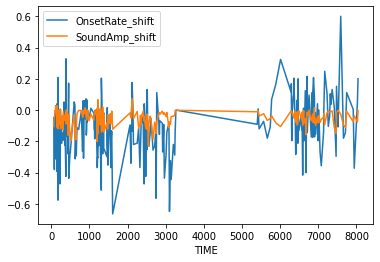

In [146]:
V.loc[:,['OnsetRate_shift','SoundAmp_shift']].plot()

In [157]:
#Stillings['Ratio'] = k
still_feats = pd.concat([Stillings,V],axis=1)
still_feats.to_csv('Draft_Stillings_with_Audio.csv')

In [159]:
print(still_feats.columns)
still_feats.corr(method='spearman')

Index(['LABEL', 'Since', 'Set', 'Movement', 'Moment', 'PointType', 'Type',
       'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end', 'Phr_begining', 'Rubato',
       'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp', 'Diminuendo', 'TextDec',
       'Drone', 'TextInc', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post',
       'SoundAmp_shift', 'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift',
       'QoMmean_pre', 'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre',
       'QoMmedian_post', 'QoMmedian_shift'],
      dtype='object')


,Since,Set,Movement,Moment,Rest,Gap,Connect,Elide,Phr_end,Phr_begining,...,SoundAmp_shift,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift
Since,1.000000,0.371153,-0.049288,0.391113,-0.182275,-0.194496,0.191939,0.170743,-0.091828,-0.148108,...,-0.176692,0.057154,0.019283,-0.012332,0.006316,-0.052658,-0.037391,-0.070347,-0.111520,-0.081614
Set,0.371153,1.000000,-0.436504,0.945509,-0.119016,-0.069750,0.132830,-0.158350,0.123294,-0.347730,...,0.005903,-0.019076,0.241681,0.262524,-0.084492,-0.103960,0.045470,-0.152874,-0.250110,-0.090754
Movement,-0.049288,-0.436504,1.000000,-0.155298,0.119138,0.051577,0.021136,-0.030913,-0.174593,-0.221999,...,-0.040949,0.073757,-0.258593,-0.227070,-0.196089,-0.217973,-0.025959,-0.042159,-0.053084,-0.015627
Moment,0.391113,0.945509,-0.155298,1.000000,-0.091814,-0.034309,0.140986,-0.181098,0.065777,-0.455527,...,-0.016546,0.003907,0.189163,0.223690,-0.157377,-0.185556,0.046829,-0.180078,-0.292601,-0.106099
Rest,-0.182275,-0.119016,0.119138,-0.091814,1.000000,0.500247,-0.574488,-0.330719,0.045600,-0.158090,...,-0.033547,-0.034315,-0.147187,-0.021895,0.053323,-0.016282,-0.046824,0.019069,-0.094124,-0.104226
Gap,-0.194496,-0.069750,0.051577,-0.034309,0.500247,1.000000,-0.815223,-0.420910,0.069777,-0.159953,...,0.060666,-0.150483,-0.132149,0.084014,-0.035559,-0.066036,-0.037514,-0.128717,-0.199942,-0.043700
Connect,0.191939,0.132830,0.021136,0.140986,-0.574488,-0.815223,1.000000,0.289960,-0.046361,0.137382,...,-0.020449,0.104696,0.121103,-0.057997,-0.030560,0.022331,0.064933,0.082819,0.137883,0.036418
Elide,0.170743,-0.158350,-0.030913,-0.181098,-0.330719,-0.420910,0.289960,1.000000,-0.015081,0.205112,...,-0.073187,0.072491,0.113392,0.008487,0.113206,0.056030,-0.100070,0.133604,0.161663,0.030797
Phr_end,-0.091828,0.123294,-0.174593,0.065777,0.045600,0.069777,-0.046361,-0.015081,1.000000,-0.028574,...,-0.016444,-0.042742,-0.097102,-0.003908,0.068382,0.055796,-0.003687,0.064800,-0.038426,-0.172467
Phr_begining,-0.148108,-0.347730,-0.221999,-0.455527,-0.158090,-0.159953,0.137382,0.205112,-0.028574,1.000000,...,-0.013417,0.131443,0.176200,-0.056730,0.190313,0.264723,0.091214,0.258831,0.328330,0.055279


In [162]:
SF = seg_df.mean(axis=1)

SF.to_csv('mean.csv')


In [237]:
Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mov_df = pd.DataFrame(columns = seg_df.columns,index=Event_ranges.keys())
seg_df = aud_df.copy()
#seg_df = seg_df.fillna(0)
for ev in Event_ranges:
    print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mov_df.loc[ev,:] = seg_df.loc[seg_start:seg_end,:].copy().mean(skipna=True)

mov_df


Beethoven
Schnittke
Bach
Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6


,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.06931,NaN,0.094418,0.101832,0.073396,0.108571,0.079436,0.086551,0.078944,0.132908,...,0.050849,0.209203,0.106643,0.16461,0.342741,0.182283,NaN,0.084129,0.271856,NaN
Schnittke,NaN,NaN,0.09243,0.143005,0.082105,0.117091,0.071236,0.084851,0.083309,0.106298,...,NaN,0.324695,0.160089,0.174854,0.288413,0.168656,NaN,NaN,0.142884,NaN
Bach,0.056344,0.135227,0.095909,0.124162,0.076236,0.103214,0.072805,0.075117,0.063814,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.043821,0.080859,0.044488,0.064076
Folk 1,0.092763,0.108706,0.113461,0.11108,0.091294,0.094409,0.108131,0.100647,0.06888,0.128617,...,0.129728,NaN,0.314134,1.029549,NaN,NaN,NaN,0.119573,0.069146,0.124333
Folk 2,0.107179,0.112969,0.134227,0.16998,0.132951,0.109864,0.169403,0.1276,0.103629,0.278259,...,0.155217,NaN,0.226191,NaN,NaN,NaN,NaN,0.077603,0.118621,0.105172
Folk 3,0.093821,0.110445,0.120349,0.200489,0.09407,0.122745,0.134144,0.181669,0.076284,0.200711,...,0.177113,NaN,NaN,NaN,NaN,NaN,NaN,0.091614,0.142352,0.086665
Folk 4,0.058239,0.104601,0.105789,0.106932,0.100064,0.093399,0.107378,0.071827,0.066724,0.08968,...,0.14281,NaN,NaN,NaN,NaN,NaN,NaN,0.084257,0.025852,0.052904
Folk 5,0.076783,0.113608,0.109129,0.2069,0.112852,0.092305,0.087781,0.09075,0.077657,0.171621,...,0.098097,NaN,NaN,NaN,NaN,NaN,NaN,0.090013,0.06018,0.077249
Folk 6,0.131336,0.122249,0.17015,0.278143,0.105464,0.129512,0.164427,0.115135,0.096362,0.254176,...,0.081031,NaN,NaN,NaN,NaN,NaN,NaN,0.111303,0.022379,0.270537


In [317]:

Cond = ['Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual'] # hall for 85 and virtual for 30
seg_df.columns.values
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}

#Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mm_df = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])
for ev in Event_ranges:
    print(ev)
    if ev.startswith('Bee'):
        sec = 'First Half'
    else:
        if ev.startswith('Sch'):
            sec = 'First Half'
        else:
            sec = 'Second Half'
    mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])
    mdf['Participant']= seg_df.columns.values
    mdf['Condition'] = Cond
    mdf['Music'] = ev
    mdf['Halfs'] = sec
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mdf.loc[:,'mQoM'] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    mm_df = pd.concat([mm_df,mdf])

#mm_df

Beethoven 1
Beethoven 2
Beethoven 3
Beethoven 4
Schnittke 1
Schnittke 2
Schnittke 3
Bach
Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6


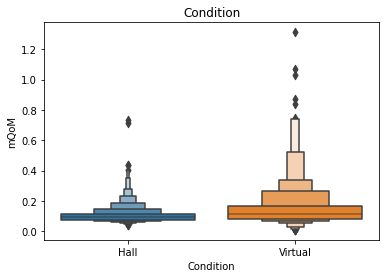

      Source  ddof1  ddof2          F         p-unc       np2
0  Condition      1   1415  82.284863  3.833997e-19  0.054956


In [280]:
sns.boxenplot(x = 'Condition',y = 'mQoM', data = mm_df)
plt.title('Condition')
#plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv='mQoM',between = 'Condition', data=mm_df)
print(aov)

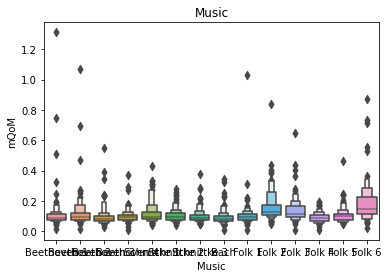

  Source  ddof1  ddof2          F         p-unc       np2       eps
0  Music     13   1001  20.177621  1.197381e-42  0.207637  0.220543


In [325]:
sns.boxenplot(x = 'Music',y = 'mQoM', data = mm_df)
plt.title('Music')
#plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.rm_anova(dv='mQoM',within = 'Music',subject='Participant', data=mm_df)
print(aov)

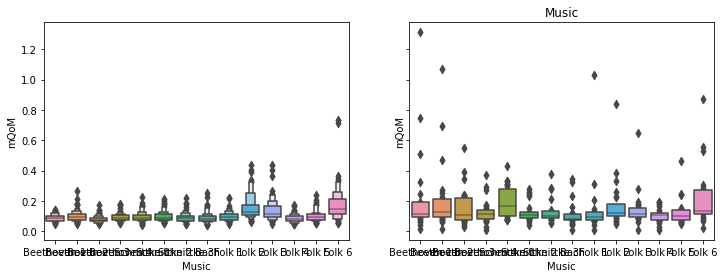

        Source        SS  DF1  DF2        MS          F         p-unc  \
0    Condition  0.165318    1   76  0.165318   6.793529  1.100507e-02   
1        Music  0.983115   13  988  0.075624  20.867935  4.697339e-44   
2  Interaction  0.171217   13  988  0.013171   3.634310  1.216332e-05   

        np2       eps  
0  0.082054       NaN  
1  0.215427  0.220543  
2  0.045637       NaN  


In [282]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,4))
sns.boxenplot(x = 'Music',y = 'mQoM', data = mm_df.loc[mm_df['Condition']=='Hall',:],ax=ax1)
sns.boxenplot(x = 'Music',y = 'mQoM', data = mm_df.loc[mm_df['Condition']=='Virtual',:],ax=ax2)
plt.title('Music')
#plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.mixed_anova(dv='mQoM',within = 'Music',between = 'Condition',subject='Participant', data=mm_df)
print(aov)

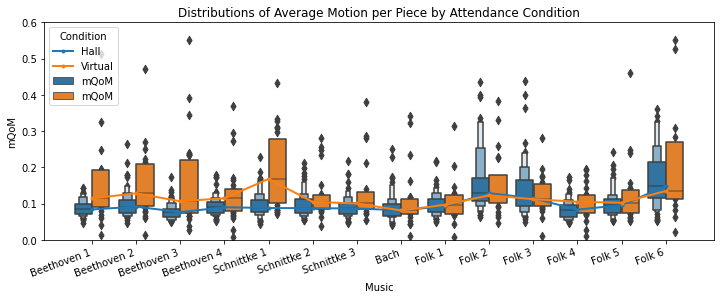

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Condition,0.165318,1,76,0.165318,6.793529,1.100507e-02,0.082054,NaN
1,Music,0.983115,13,988,0.075624,20.867935,4.697339e-44,0.215427,0.220543
2,Interaction,0.171217,13,988,0.013171,3.634310,1.216332e-05,0.045637,NaN


In [328]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))

sns.boxenplot(x = 'Music',y = 'mQoM', hue = 'Condition',data = mm_df, ax = ax1)
groupby = mm_df.loc[mm_df['Condition']=='Hall',:].groupby('Music', axis=0)
A = groupby.median()
A.loc[Event_ranges.keys(),:].plot(style = '.-',linewidth = 2,ax = ax1)
groupby = mm_df.loc[mm_df['Condition']=='Virtual',:].groupby('Music', axis=0)
A = groupby.median()
A.loc[Event_ranges.keys(),:].plot(style = '.-',linewidth = 2,ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Distributions of Average Motion per Piece by Attendance Condition')
plt.ylim([0,0.6])
plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv='mQoM',within = 'Music',between = 'Condition',subject='Participant', data=mm_df)


# decrease statistics

In [195]:
V_df = pd.DataFrame(index = music_index)
seg_df = aud_df.copy()
seg_df = seg_df.fillna(0)
k=[]
for i in music_index:
    pre_snip_df = seg_df.loc[i-3:i-2].mean(axis=0).values
    post_snip_df = seg_df.loc[i+0:i+1].mean(axis=0).values
#     V.loc[i,:] = sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df)
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))
V_df['Ratio'] = k

In [193]:
len(k)

151890

In [213]:
pre_snip_df

array([0.04758025, 0.09351164, 0.13288779, 0.1700191 , 0.07431484,
       0.05965423, 0.22654092, 0.06498265, 0.08928495, 0.10330294,
       0.20507262, 0.0819663 , 0.05239343, 0.38748071, 0.33778125,
       0.07661638, 0.06703277, 0.19251897, 0.10509274, 0.11085345,
       0.        , 0.        , 0.15611003, 0.19507034, 0.23866056,
       0.09530288, 0.42512133, 0.05004943, 0.        , 0.07227691,
       0.06030675, 0.        , 0.15371142, 0.07584863, 0.16307315,
       0.08060429, 0.12754605, 0.1389961 , 0.        , 0.09573578,
       0.23853194, 0.11084187, 0.25175829, 0.24604135, 0.04554618,
       0.06905029, 0.16825414, 0.05518462, 0.26540499, 0.17457936,
       0.08160449, 0.12702632, 0.10111928, 0.09681408, 0.2287086 ,
       0.13798385, 0.05638614, 0.        , 0.09474067, 0.22759988,
       0.06613069, 0.04428343, 0.17274336, 0.0925056 , 0.        ,
       0.        , 0.04112407, 0.06330142, 0.13191065, 0.05212238,
       0.09200525, 0.        , 0.        , 0.05094025, 0.63415

<AxesSubplot:>

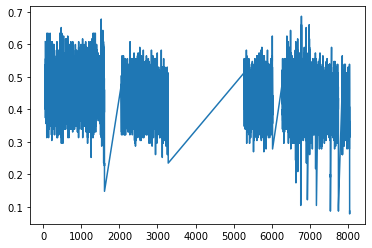

In [196]:
V_df.plot(legend = False)

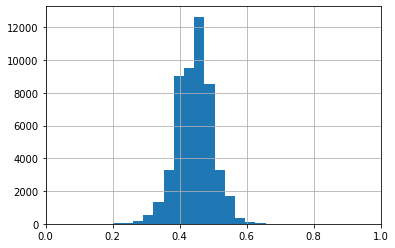

In [203]:
V_df.loc[:,'Ratio'].hist(bins=20)
plt.xlim([0,1])
plt.show()

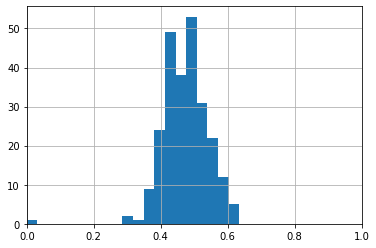

In [204]:
Stillings.loc[:,'Ratio'].hist(bins=20)
plt.xlim([0,1])
plt.show()

In [209]:
print([Stillings.loc[:,'Ratio'].median(),V_df.loc[:,'Ratio'].median()])
sp.stats.ks_2samp(Stillings.loc[:,'Ratio'], V_df.loc[:,'Ratio'], alternative='less')

[0.46956521739130436, 0.4434782608695652]


KstestResult(statistic=0.23137887715993066, pvalue=3.1820952906009645e-12)

So by komolgrov-smirnoff test, the distribution of decreased ratios is higher at the identified stilling point than through the music generally. This is without reduction from initial score/audio criteria, not yet culling the Fps and finales for example. The difference isn't big, but it's significant and encouraging. Reason to reassess criteria for misleading results. 

In [212]:
Still_times.loc[Still_times.Ratio<0.4,:]

,LABEL,Since,Set,Movement,Moment,PointType,Type,Rest,Gap,Connect,...,Rit,Fermata,Precision,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
61.320,2.5,3.90,1,1,1,Low_Rest,Rest,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.382609
114.781,27.5,3.70,1,1,7,Low_Rest,Low_onset,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.347826
291.192,113.5,9.24,1,1,27,Low_Rest,Elision,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382609
844.110,20.83,7.27,1,3,61,Low_Rest,0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.373913
1226.690,NewPoint,6.53,1,4,87,Low_Rest,0,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.356522
1608.510,NewPoint,24.93,1,4,112,Low_Rest,0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.373913
2091.040,NewPoint,4.51,2,1,116,Low_Rest,Low_Rest,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.356522
2667.440,NewPoint,56.11,2,2,143,Low_Rest,Low_Rest,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.373913
3199.330,86.00,57.07,2,3,162,Low_Rest,Low_Rest,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.373913
